In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
os.environ["OMP_NUM_THREADS"]="6"
from transformers import BertModel, BertTokenizer
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Show all rows
pd.set_option('display.max_rows', None)

# Show all columns
pd.set_option('display.max_columns', None)

# Optionally, you can also increase the display width if your DataFrame is wide
pd.set_option('display.width', None)

# Optionally, set the maximum number of characters per column (increase if needed)
pd.set_option('display.max_colwidth', None)

In [2]:
# Load data

vanity_plates = pd.read_csv("combined_reviewed_ca_plates.csv")
vanity_plates.sample(20)

FileNotFoundError: [Errno 2] No such file or directory: 'combined_reviewed_ca_plates.csv'

In [25]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")

In [26]:
def get_plate_meaning_cls(plate_meaning):
    input_ids = torch.tensor([tokenizer.encode(plate_meaning, add_special_tokens=True, max_length=512)])
    
    with torch.no_grad():
        outputs = model(input_ids)
        cls_embedding = outputs[0][:, 0, :]
    return cls_embedding.flatten()

# sample_plate_meaning = vanity_plates.sample(1).iloc[0]["meaning"]

# get_plate_meaning_cls(sample_plate_meaning)

In [76]:
# Get Meaning Embeddings

vanity_plates_with_meaning_embeddings = vanity_plates.copy()

vanity_plates_with_meaning_embeddings["meaning_embedding"] = vanity_plates_with_meaning_embeddings["meaning"].apply(get_plate_meaning_cls)

KeyboardInterrupt: 

In [77]:
vanity_plates_with_meaning_embeddings.sample(20)

,index,plate,review_reason_code,customer_meaning,reviewer_comments,status,valid,meaning
628,9318,GFATHER,7,GOOD DAD,GODFATHER? GFATER?,N,1,GOOD DAD
1058,9838,BLACKD2,NaN,BLACK D2(CAR MODEL),OR BLACK D AS IN DICK TOO,N,3,BLACK D2(CAR MODEL) OR BLACK D AS IN DICK TOO
967,11629,SKNDLUS,1,MY NEW CAR IS BLACK AND A CONVERTABLE AND IS SCANDULUS!!!,SCANDALOUS,Y,2,SCANDALOUS
230,7263,CHRRBMB,2,CHERRY BOMB IS THE NAME OF MY 1999 RED MAZDA MIATA,BOMB,N,1,CHERRY BOMB IS THE NAME OF MY 1999 RED MAZDA MIATA
944,14004,BISH417,3,LAST NAME & LUCKY NUMBERS,"BISH COULD MEAN BITCH, CUSTOMER NAME IS BISHOP. 417 IS MISSOURI AREA CODE NOT CA",N,1,LAST NAME & LUCKY NUMBERS
1331,6367,SCAT2NV,2,FOR A 2015 DODGE CHALLENGER SCAT PACK TO ENVY,SHIT TO ENVY SCAT MEANS FECES,N,1,FOR A 2015 DODGE CHALLENGER SCAT PACK TO ENVY
943,12595,ABG 1V,2,NO MICRO,ABG MEANS AZNBBYGIRL OR ASIAN FEMALE GANGSTER,N,2,ABG MEANS AZNBBYGIRL OR ASIAN FEMALE GANGSTER
1436,8260,CAVERAO,1 OR 2,in Brazil is a nickname for a big car,means skull in Portuguese (which is slang for oral sex in English) also means Special Police Armored Vehicle in Brazil,N,2,means skull in Portuguese (which is slang for oral sex in English) also means Special Police Armored Vehicle in Brazil
648,8398,POLEDCR,1,POLE DANCER,POLE DANCER,Y,1,POLE DANCER
874,5159,BOM 1,2,BRETHREN OF THE MARGARITA,BOMB,N,2,BOMB


c:\Users\John\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
c:\Users\John\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
c:\Users\John\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
c:\Users\John\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows wi

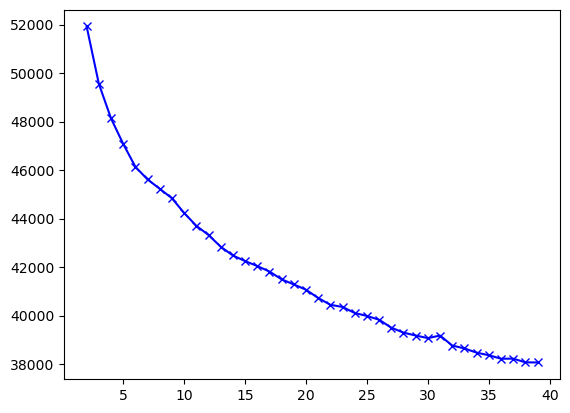

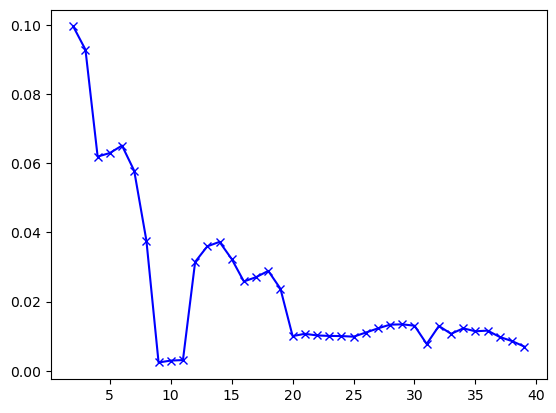

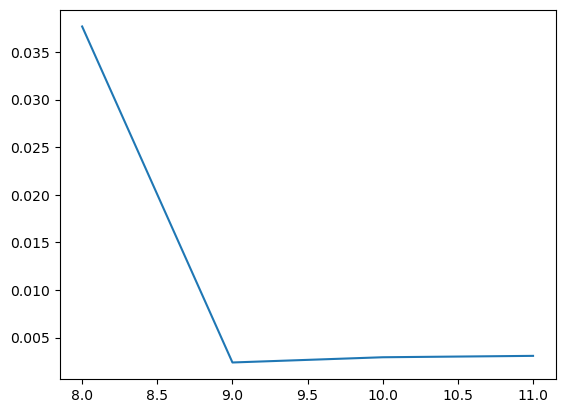

In [48]:
# Cluster into groups

stacked_meanings = np.vstack(vanity_plates_with_meaning_embeddings["meaning_embedding"])
max_clusters = 40
def test_kmeans_num_clusters(num_clusters):
    kmeans_model = KMeans(num_clusters, random_state=42)
    kmeans_model.fit(stacked_meanings)
    return kmeans_model.inertia_, silhouette_score(stacked_meanings, kmeans_model.labels_)

silhouette_score_avg = []
squared_distance_sums = []
for num_clusters in range(2, max_clusters):
    squared_distance_sum, silhouette_score_val = test_kmeans_num_clusters(num_clusters)
    squared_distance_sums.append(squared_distance_sum)
    silhouette_score_avg.append(silhouette_score_val)

plt.plot(range(2, max_clusters), squared_distance_sums, 'bx-')
plt.show()

plt.plot(range(2, max_clusters), silhouette_score_avg, "bx-")
plt.show()

plt.plot(range(8, 12), silhouette_score_avg[6:10])
plt.show()

In [ ]:
# Classify plates

kmeans_model = KMeans(9, random_state=42)
kmeans_model.fit(stacked_meanings)

predictions = kmeans_model.predict(stacked_meanings)
vanity_plates_with_meaning_embeddings["classification"] = predictions

c:\Users\John\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


In [58]:
classification_counts = vanity_plates_with_meaning_embeddings.groupby("classification").count()

# Now, we want to convert this into a DataFrame with "count" as the column
# We will take the first column from the grouped DataFrame and rename it to "count"

classification_counts = classification_counts.iloc[:, [0]].reset_index()
classification_counts.columns = ['classification', 'count']

classification_counts['percentage'] = (classification_counts['count']/len(vanity_plates_with_meaning_embeddings)) * 100

classification_counts

,classification,count,percentage
0,0,69,4.693878
1,1,261,17.755102
2,2,143,9.727891
3,3,63,4.285714
4,4,341,23.197279
5,5,136,9.251701
6,6,125,8.503401
7,7,154,10.476190
8,8,178,12.108844


In [65]:
sampled_df = vanity_plates_with_meaning_embeddings.groupby('classification').apply(lambda x: x.sample(n=20, random_state=42))

sampled_df = sampled_df.reset_index(drop=True)

# sampled_df[["plate", "meaning", "classification"]]

C:\Users\John\AppData\Local\Temp\ipykernel_27664\1196939577.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = vanity_plates_with_meaning_embeddings.groupby('classification').apply(lambda x: x.sample(n=20, random_state=42))


In [67]:
cluster_meanings = {
    0: "Weapons, Cars, and Masculine Themes - Includes references to firearms, high-performance cars, and tough or aggressive themes.",
    1: "Humor, Personal, and Playful - Plates with personal jokes, playful humor, and light-hearted references.",
    2: "Sexual, Offensive, and Controversial - Plates with sexual references, profanity, and controversial or offensive language.",
    3: "Personal, Family, and Sentimental - Plates that reflect personal milestones, family connections, and sentimental values.",
    4: "Profanity, Drug, and Gang References - Plates with profanity, drug-related terms, and references to gangs or criminal culture.",
    5: "Defiant, Rebellious, and Aggressive - Plates with a rebellious or defiant attitude, often with expressions of aggression or boldness.",
    6: "Humorous, Quirky, and Personal - Plates featuring humor, quirky personal references, and light-hearted expressions.",
    7: "Sports, Teams, and Regional References - Plates with references to sports teams, local pride, and regional identifiers.",
    8: "Sexual and Provocative - Plates with explicit sexual references and provocative, bold language.",
    9: "Miscellaneous, Humorous, and Offbeat - Plates with random, quirky, or offbeat themes that don't fit into other categories."
}

cluster_meanings_short = {
    0: "Weapons, Cars, Masculine Themes",
    1: "Humor, Personal, Playful",
    2: "Sexual, Offensive, Controversial",
    3: "Personal, Family, Sentimental",
    4: "Profanity, Drugs, Gang References",
    5: "Defiant, Rebellious, Aggressive",
    6: "Humorous, Quirky, Personal",
    7: "Sports, Teams, Regional",
    8: "Sexual, Provocative",
    9: "Miscellaneous, Offbeat"
}

In [71]:
vanity_plates_with_meaning_embeddings["string_classification"] = vanity_plates_with_meaning_embeddings["classification"].apply(lambda x: cluster_meanings_short[x])

vanity_plates_with_meaning_embeddings[["plate", "meaning", "classification", "string_classification"]].sample(20)

,plate,meaning,classification,string_classification
827,AUDZNTZ,"AWW, DEEZ NUTS",8,"Sexual, Provocative"
828,HOP2BCH,HOP TO BITCH,5,"Defiant, Rebellious, Aggressive"
260,1CUSHJD,URBAN DICTIONARY SAYS IT IS HYDROPHONIZ MARIJUANA AND KUSH IS A MAGAZINE ON MARIJUANA,4,"Profanity, Drugs, Gang References"
313,ITZ DOPE,ITS COOL,1,"Humor, Personal, Playful"
1373,SPTHLK,SPECIAL K IS A SLANG WORD FOR A TYPE OF DRUG,4,"Profanity, Drugs, Gang References"
653,4TNT,FOR TNT,1,"Humor, Personal, Playful"
585,MMEOWWW,CAT LOVER,1,"Humor, Personal, Playful"
481,DEAD1CO,DEAD AND CO IS THE NAME OF A BAND I LOVE,1,"Humor, Personal, Playful"
512,BACINGA,CAN MEAN FOOLED YOU WHEN JOKING AROUND AND PLAYING PRANKS ON PEOPLE BUT IT CAN ALSO MEAN COCK SUCKER IN GERMAN,2,"Sexual, Offensive, Controversial"
1372,GTHOM88,MISSISSIPPI STATE ALUMNI CHEER AND YEAR GRADUATED,3,"Personal, Family, Sentimental"


In [75]:
vanity_plates_with_meaning_embeddings[["plate", "meaning", "classification", "string_classification"]].to_csv("john_final_classified_vanity_plates_with_meaning.csv", index=True, index_label="index")

In [3]:
combined_clustered_plates = pd.read_csv("combined_clustered_plates_with_classified_majority_vote.csv")